# Final Model
Group 42: Elise Penn, Manish Vuyyuru, Victor Sheng, Yajaira Gonzalez

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV
from sklearn.base import clone
from sklearn.metrics import r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 
from sklearn.metrics import log_loss
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

# Functions

In [2]:
def upsample(test, monsterframe=False):
    '''
    input: test (pandas.dataframe)
    output: pandas.dataframe
    
    input dataframe MUST have the columns dem_win_prev and dem_win
    function will ensure that there are an equal number of flips and no flips in the dataset via bootstrap
    '''
    
    #check if party flip as per usual
    test['party_flip'] = (test.dem_win_prev != test.dem_win)*1
    #drop 2018 rows as we want to test on these, don't mess with them
    test = test[test['year'] != 2018]
    #count number of flips and no flips
    print(np.sum((test['party_flip']==1)), np.sum((test['party_flip']==0)))
    #we want to match these counts, so we need target number of bootstrapped samples
    target = (np.sum((test['party_flip']==0))) - (np.sum((test['party_flip']==1)))
    #collect target bootstrap samples where we see a flip
    samples = test[test['party_flip'] == 1].sample(n=target, replace=True)
    #add them back to the dataframe
    test = pd.concat([test, samples])
    print(np.sum((test['party_flip']==1)), np.sum((test['party_flip']==0)))
    print(len(set(test[test['party_flip'] == 1].index)))
    test = test.drop('party_flip', axis=1)
    
    if monsterframe:
        target = 5*(len(test))
        samples = test.sample(n=target, replace=True)
        test = pd.concat([test, samples])
    print(len(test))
    
    
    
    return test

#full_dataset = boostrap(full_dataset)

In [3]:
# format data items for input into the model

def format_model_input(filename, x_cols, y_col, state_hot_encoder=False, upsample=False):
    
    # load full dataset 
    full_dataset = pickle.load(open(filename, 'rb'))
    
    # train data is everything except 2018
    if upsample:
        pre_2018_dataset = full_dataset.loc[full_dataset['year']!=2018]
        pre_2018_dataset = upsample(pre_2018_dataset, monsterframe=False)
    else:
        pre_2018_dataset = full_dataset.loc[full_dataset['year']!=2018]

    X_train = pre_2018_dataset[cols_to_use]
    y_train = pre_2018_dataset[y_col]
    flip_train = np.abs(pre_2018_dataset['dem_win']-pre_2018_dataset['dem_win_prev'])
    
    # test data is 2018
    the_2018_dataset = full_dataset.loc[full_dataset['year']==2018]
    X_test = the_2018_dataset[cols_to_use]
    y_test = the_2018_dataset[y_col]
    flip_test = np.abs(the_2018_dataset['dem_win']-the_2018_dataset['dem_win_prev'])
    
    if state_hot_encoder:
        #add one hot encoder for states (with or without dropping first)
        X_train.loc[:,'state'] = pre_2018_dataset['state']
        X_train = pd.get_dummies(X_train,prefix='state',columns=['state'], drop_first=True)
        X_test.loc[:,'state'] = the_2018_dataset['state']
        X_test = pd.get_dummies(X_test,prefix='state',columns=['state'], drop_first=True)
        
        # Make sure train and test have all the same states
            # the problem is that PA is no longer in the test set...
        states_missing_in_test = np.array([x for x in X_train.columns.values if x not in X_test.columns.values])
        if states_missing_in_test.size!=0:
            for state_missing in states_missing_in_test:
                X_test[state_missing] = 0
    
    return X_train,y_train, X_test,y_test, flip_train,flip_test

In [4]:
# plot all metric specified on the model and dataset specificed
# outputs subplot

def plot_metrics(ax,model_dict, X_train_input, y_train_input, X_test_input, y_test_input, 
                 flip_train, flip_test, score='accuracy_score'):
    
    df_for_plotting = pd.DataFrame()
    for model_name, model in model_dict.items():
        dict_for_plotting = {}
        # copy arrays so you don't accidentally change them 
        X_train = X_train_input.copy()
        y_train = y_train_input.copy()
        X_test = X_test_input.copy()
        y_test = y_test_input.copy()
        
        # get the flip and noflip data
        #flip_mask_train = np.array(flip_train)==1
        flip_mask_test = np.array(flip_test)==1

        # calculate metrics
        if score=='accuracy_score':
            # predict test and train data
            y_pred_test = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            
            # calculate accuracy score
            y_pred_train = y_pred_train.round()
            y_pred_test = y_pred_test.round()
            train_score = accuracy_score(y_train, y_pred_train)
            test_score = accuracy_score(y_test, y_pred_test)
            percent_noflip_correct = accuracy_score(y_test[~flip_mask_test], y_pred_test[~flip_mask_test])
            percent_flip_correct = accuracy_score(y_test[flip_mask_test],y_pred_test[flip_mask_test])

            # colors and names for the plot
            metric_name = 'accuracy'
            palette = {'train_'+metric_name  : sns.color_palette("Paired")[0], 
                       'test_'+metric_name   : sns.color_palette("Paired")[1],
                       'noflip_'+metric_name : sns.color_palette("Paired")[2], 
                       'flip_'+metric_name   : sns.color_palette("Paired")[3] }
            
        elif score=='log_loss':    
            # predict_proba test and train data
            y_prob_test = model.predict_proba(X_test)
            y_prob_train = model.predict_proba(X_train)
            
            # calculate logloss
            train_score = log_loss(y_train, y_prob_train)
            test_score = log_loss(y_test, y_prob_test)
            percent_noflip_correct = log_loss(y_test[~flip_mask_test], y_prob_test[~flip_mask_test])
            percent_flip_correct = log_loss(y_test[flip_mask_test],y_prob_test[flip_mask_test])
            
            # colors and names for the plot
            metric_name = 'logloss'
            palette = {'train_'+metric_name  : sns.color_palette("Paired")[4], 
                       'test_'+metric_name   : sns.color_palette("Paired")[5],
                       'noflip_'+metric_name : sns.color_palette("Paired")[6], 
                       'flip_'+metric_name   : sns.color_palette("Paired")[7] }
            ax.set_ylim(0,35)
            
        elif score=='r2_score':
            # predict_proba test and train data
            y_prob_test = model.predict_proba(X_test)[:,1]
            y_prob_train = model.predict_proba(X_train)[:,1]
            
            # calculate r2 score
            train_score = r2_score(y_train, y_prob_train)
            test_score = r2_score(y_test, y_prob_test)
            percent_noflip_correct = r2_score(y_test[~flip_mask_test], y_prob_test[~flip_mask_test])
            percent_flip_correct = r2_score(y_test[flip_mask_test],y_prob_test[flip_mask_test])
            
            # colors and names for the plot
            metric_name = 'r2'
            palette = {'train_'+metric_name  : sns.color_palette("Paired")[8], 
                       'test_'+metric_name   : sns.color_palette("Paired")[9],
                       'noflip_'+metric_name : sns.color_palette("Paired")[10], 
                       'flip_'+metric_name   : sns.color_palette("Paired")[11] }
            
        # train score
        dict_for_plotting['model_name'] = model_name
        dict_for_plotting['metric_name'] = 'train_'+metric_name
        dict_for_plotting['metric'] = train_score
        df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

        # test score
        dict_for_plotting['model_name'] = model_name
        dict_for_plotting['metric_name'] = 'test_'+metric_name
        dict_for_plotting['metric'] = test_score
        df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

        # percent noflip
        dict_for_plotting['model_name'] = model_name
        dict_for_plotting['metric_name'] = 'noflip_'+metric_name
        dict_for_plotting['metric'] = percent_noflip_correct
        df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

        # percent flip
        dict_for_plotting['model_name'] = model_name
        dict_for_plotting['metric_name'] = 'flip_'+metric_name
        dict_for_plotting['metric'] = percent_flip_correct
        df_for_plotting = df_for_plotting.append(dict_for_plotting,ignore_index=True)

    sns.barplot(x='model_name', y='metric', hue='metric_name', data=df_for_plotting,
               palette=palette, ax=ax)

In [5]:
# plot flips predicted by a model

def plot_flips(X_test_input, y_test_input, y_pred_test_input, flip_train, 
               flip_test, model_name):
    
    # copy arrays so you don't accidentally change them 
    X_test = X_test_input.copy()
    y_test = y_test_input.copy()
    y_pred_test = y_pred_test_input.copy()
    
    # add flip data to the array
    X_test['party_flip'] = flip_test
    
    #looking at the missclassifications with logisticRegressionCV
    miss_class_df = X_test[y_test != y_pred_test]
    good_class_df = X_test[y_test == y_pred_test]

    #plot the flips and non flips for each data
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    ax[0].set_title(model_name+' Proportion of party flips on wellclassified test data')
    ax[1].set_title(model_name+' Proportion of party flips missclassified test data')

    if not good_class_df.empty:
        good_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[0])
        for name, group in (good_class_df.groupby('party_flip')['party_flip']):
            ax[0].text(int(name)+.25, group.count() + .25, \
            '{0:.2f}'.format(group.count()/good_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

    if not miss_class_df.empty:
        miss_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[1])
        for name, group in (miss_class_df.groupby('party_flip')['party_flip']):
            ax[1].text(int(name)+.15, group.count() + .25, \
            '{0:.2f}'.format(group.count()/miss_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')
            
    normnoflip = len(X_test[X_test['party_flip'] == 0])
    normflip = len(X_test[X_test['party_flip'] == 1])
    print('predicted correctly. does not flip.: {}'.format(len(good_class_df[good_class_df['party_flip'] == 0])/normnoflip))
    print('predicted wrongly. does not flip.: {}'.format(len(miss_class_df[miss_class_df['party_flip'] == 0])/normnoflip))
    
    print('predicted correctly. does flips.: {}'.format(len(good_class_df[good_class_df['party_flip'] == 1])/normflip))
    print('predicted wrongly. does flips.: {}'.format(len(miss_class_df[miss_class_df['party_flip'] == 1])/normflip))
        
    plt.show()

In [6]:
# plot a scatter plot of the probabilities predicted by the model. 

def scatter_results(ax, fitted_model_dict, X_test, y_test, flip, model_name='LogReg'):
    model = fitted_model_dict[model_name]
    y_prob = model.predict_proba(X_test)[:,1]
    
    flip = flip.values.squeeze()
    y_test = y_test.values.squeeze()
    y_dem_flip = y_prob[np.logical_and(y_test==1, flip==1)]
    y_dem_noflip = y_prob[np.logical_and(y_test==1, flip==0)]
    y_rep_flip = y_prob[np.logical_and(y_test==0, flip==1)]
    y_rep_noflip = y_prob[np.logical_and(y_test==0, flip==0)]
    
    ax.plot(y_dem_noflip,'b.',label='D, No Flip')
    ax.plot(y_dem_flip,'b*', label = 'D, Flip')
    ax.plot(y_rep_noflip,'r.', label = 'R, No Flip')
    ax.plot(y_rep_flip,'r*', label = 'R, Flip')
    
    plt.xlabel('index')
    plt.ylabel('rep-dem')
    plt.legend()
    ax.set_title(model_name+' Results')
    ax.axhline(0.5)
    
    print('We predicted democrats got {} spots.'.format(np.sum(y_prob.round()==1)))
    print('We predicted republicans got {} spots.'.format(np.sum(y_prob.round()==0)))

In [7]:
# print out R2, accuracy, and plot # flipped seats correctly predicted for a given model

def report_model_stats(filename, x_cols, y_col, model_dict, state_hot_encoder=False, upsample=False, title=''):
    
    # read in the desired data
    X_train,y_train, X_test,y_test, flip_train,flip_test = \
        format_model_input(filename, cols_to_use, y_col, state_hot_encoder)
        
    fitted_model_dict = {}
    
    for model_name, model in model_dict.items():
        model_copy = clone(model) # deep copy model to prevent fitting it twice
#         print(model_name)

        fitted_model = model_copy.fit(X_train,y_train)
        y_pred_test = fitted_model.predict(X_test)

#         print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred_test.round()))
#         print("\n{} R2: ".format(model_name), fitted_model.score(X_train,y_train))
#         print("{} Test Accuracy".format(model_name), accuracy_score(y_test,y_pred_test.round()))
#         plot_flips(X_test, y_test, y_pred_test.round(), flip_train, flip_test, model_name)
        
        fitted_model_dict[model_name] = fitted_model
        
        
#         try:
#             coef = fitted_model.coef_.squeeze()
#             print(len(X_test.columns), len(coef))
#             print('intercept = {}'.format(fitted_model.intercept_))
#             print([i for i in zip(X_test.columns,coef)])
#         except AttributeError:
#             print('doesnt have any coefficients')
    
    # plot all the metrics
    fig, ax = plt.subplots(1,3,figsize=(16,4))
    plot_metrics(ax[0],fitted_model_dict, X_train, y_train, X_test, y_test, flip_train, flip_test, score='accuracy_score')
    plot_metrics(ax[1],fitted_model_dict, X_train, y_train, X_test, y_test, flip_train, flip_test, score='log_loss')
    scatter_results(ax[2], fitted_model_dict, X_test, y_test, flip_test)

    # rotate tickmarks 45 degrees
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=45)
    
    fig.suptitle(title)
    plt.show()
    
    return fitted_model_dict

In [8]:
# makes a plot to visualize collinearity between predictors

def collinear(filename, x_cols, state_hot_encoder=False,y_col='dem_win'):
    X_train,y_train, X_test,y_test, flip_train,flip_test = \
        format_model_input(filename, cols_to_use, y_col, state_hot_encoder)
    sns.heatmap(np.abs(X_train[x_cols].corr()),xticklabels=True,yticklabels=True,
                vmin = 0, vmax=1)
    plt.rcParams['figure.figsize'] = (12,8)
    plt.title('collinearity of predictors considered')

# Visualization of predictors

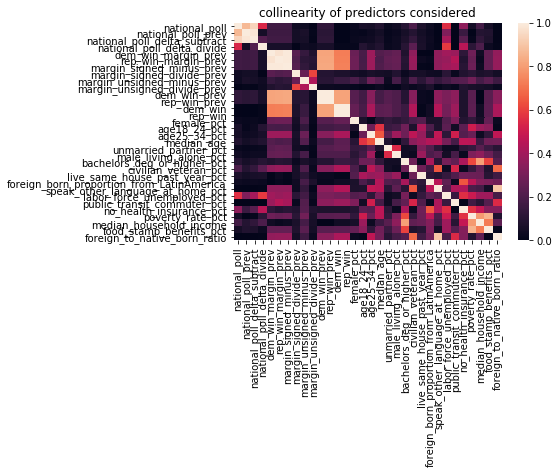

In [9]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
cols_to_use = [ 'national_poll', 'national_poll_prev', 
               'national_poll_delta_subtract', 
               'national_poll_delta_divide', 'previous_party', 
               'dem_win_margin_prev', 'rep_win_margin_prev', 
               'margin_signed_minus_prev', 'margin_signed_divide_prev', 
               'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev', 
               'dem_win_prev', 'rep_win_prev', 'dem_win', 'rep_win',
               'female_pct', 'age18_24_pct', 
               'age25_34_pct', 'median_age', 'unmarried_partner_pct', 
               'male_living_alone_pct', 'bachelors_deg_or_higher_pct', 
               'civilian_veteran_pct', #'past_year_births_to_unmarried_women_pct', # has a string in it
               'live_same_house_past_year_pct', 
               'foreign_born_proportion_from_LatinAmerica', 
               'speak_other_language_at_home_pct', 'labor_force_unemployed_pct', 
               'public_transit_commuter_pct', 'no_health_insurance_pct', 
                'poverty_rate_pct', 'median_household_income', # 'median_housing_value', # has a string in it
                'food_stamp_benefits_pct', 'foreign_to_native_born_ratio' 
              ] # everything

collinear(filename,cols_to_use)


# filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018.p'
# collinear(filename,cols_to_use)

# Try out different models 
Change the variables below to try out different models. 

### These are potential predictors you could include in the model:

['district', 'state', 'year', 'party', 'candidatevotes', 'totalvotes',
       'candidate', 'national_poll', 'national_poll_prev',
       'national_poll_delta_subtract', 'national_poll_delta_divide',
       'previous_party', 'dem_win_margin_prev', 'rep_win_margin_prev',
       'margin_signed_minus_prev', 'margin_signed_divide_prev',
       'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev',
       'dem_win_prev', 'rep_win_prev', 'dem_win', 'rep_win', 'female_pct',
       'age18_24_pct', 'age25_34_pct', 'median_age', 'unmarried_partner_pct',
       'male_living_alone_pct', 'bachelors_deg_or_higher_pct',
       'past_year_births_to_unmarried_women_pct', 'civilian_veteran_pct',
       'live_same_house_past_year_pct',
       'foreign_born_proportion_from_LatinAmerica',
       'speak_other_language_at_home_pct', 'labor_force_unemployed_pct',
       'public_transit_commuter_pct', 'no_health_insurance_pct',
       'poverty_rate_pct', 'median_housing_value', 'median_household_income',
       'food_stamp_benefits_pct', 'foreign_to_native_born_ratio']
       
### These are potential datasets you could use for the model: 

data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_DISTRICTMIXED_2004_2018.p

data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018_REDISTRICTDROP.p

data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018.p

data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p

data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p

data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p

data_FEC_NATIONALPOLL_2004_2018.p

If you are running this from the Github repo, remember that all of these datasets are in the Datasets/ folder. 

We predicted democrats got 196 spots.
We predicted republicans got 226 spots.


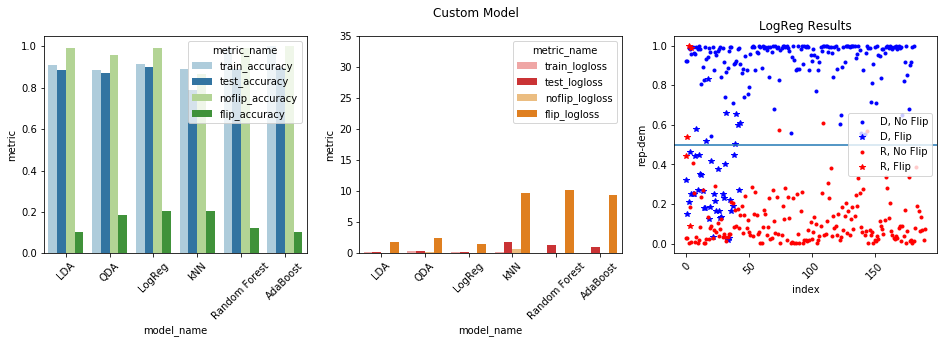

In [10]:
#****************************
# COMMON VARIABLES TO CHANGE
#****************************
# specify the dataset you want to use
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_DISTRICTMIXED_2004_2018.p'
# specify which predictors to use here
cols_to_use = ['national_poll', 'margin_signed_minus_prev', 
               'female_pct', 'foreign_to_native_born_ratio', 
               'age18_24_pct', 'age25_34_pct'] 

# do you want to try upsampling flipped districts?
upsample = False 
# do you want to one-hot-encode states?
state_hot_encoder = False 


#*********************************
# LESS COMMON VARIABLES TO CHANGE
#*********************************
# specify which column you are predicting
y_col = ['dem_win'] 
# specify your models to use here:
model_dict = {
    'LDA'           : LDA(),
    'QDA'           : QDA(),
    'LogReg'        : LogisticRegression(n_jobs=4),
    'kNN'           : KNeighborsClassifier(n_neighbors=4,n_jobs=4),
    'Random Forest' : RandomForestClassifier(n_jobs=4,random_state=209),
    'AdaBoost'      : AdaBoostClassifier(DecisionTreeClassifier(max_depth=10)),
}


#*************************************
# The model & visualizations run here
#*************************************
fitted_model_dict = report_model_stats(
    filename, cols_to_use, y_col, model_dict, state_hot_encoder=False, upsample=upsample,
    title='Custom Model')